# Imports

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
from scipy.linalg import pinv
from matplotlib.lines import Line2D
from math import ceil

# IOC Step

(For each window, compute the six IOC term values (one scalar per term))
- Implement an inverse optimal control step that infers cost weights q = [w_posture, w_symmetry, w_smoothness, w_variability, w_range, w_effort] from the observed movement data in each window.
- Keep the optimization simple — the main goal is to map features → cost weights, not to build a full biomechanical model.


In [ ]:
def compute_ioc_terms(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build six IOC term *costs* (higher = worse).
    Expects the columns listed in features_for_ioc.csv.
    """
    out = pd.DataFrame(index=df.index)

    # Posture – median joint angles, median positions (elbows, knees, wrists, ankles)
    out["posture"] = df[[
        "posture_median_angle_elbows",
        "posture_median_angle_knees",
        "posture_median_pos_wrists",
        "posture_median_pos_elbows",
        "posture_median_pos_ankles",
        "posture_median_pos_knees",
    ]].mean(axis=1)

    # Symmetry – use a cost: 1 - |ρ|  (so perfect symmetry → 0 cost)
    sym_costs = []
    for c in ["sym_wrists", "sym_elbows", "sym_knees", "sym_ankles"]:
        sym_costs.append(1.0 - df[c].clip(-1, 1).abs())
    out["symmetry"] = np.vstack(sym_costs).T.mean(axis=1)

    # Smoothness – RMS jerk, IQR velocity  (higher => worse)
    out["smoothness"] = df[["smooth_rms_jerk", "smooth_iqr_vel"]].mean(axis=1)

    # Variability/complexity – entropy of positions / angles (higher => worse)
    out["variability"] = df[[
        "var_entropy_wrists","var_entropy_elbows","var_entropy_ankles","var_entropy_knees",
        "var_entropy_angles_elbows","var_entropy_angles_knees"
    ]].mean(axis=1)

    # Range – IQR position / joint angles (higher => wider / worse)
    out["range"] = df[["range_iqr_pos","range_iqr_angle_elbows","range_iqr_angle_knees"]].mean(axis=1)

    # Effort – median velocity, IQR acceleration (higher => more effort)
    out["effort"] = df[["effort_median_vel","effort_iqr_acc"]].mean(axis=1)

    return out

In [4]:
def normalize_terms_global(terms_df: pd.DataFrame) -> pd.DataFrame:
    scaler = RobustScaler()  # uses median and IQR (robust to outliers)
    arr = scaler.fit_transform(terms_df.values)
    return pd.DataFrame(arr, index=terms_df.index, columns=terms_df.columns)

In [6]:
def fit_weights_for_window(t_obs: np.ndarray,
                           T_decoys: np.ndarray,
                           reg: float = 1e-2,
                           lr: float = 0.3,
                           iters: int = 400) -> np.ndarray:
    """
    Infer 6D cost weights for a single window using decoy ranking.
    Returns w (6,), w >= 0, sum(w)=1
    """
    K = len(T_decoys)
    if K == 0:
        return np.ones(6) / 6.0

    u = np.zeros(6)  # logits

    for _ in range(iters):
        # softmax → simplex
        e = np.exp(u - u.max())
        w = e / e.sum()

        diffs = t_obs[None, :] - T_decoys   # (K,6)
        s = diffs @ w                       # (K,)

        # Correct objective for "t_obs cheaper than decoys"
        # L = mean log(1 + exp(s)) + reg * ||w||^2
        # d/ds log(1+exp(s)) = sigmoid(s)
        sig = 1.0 / (1.0 + np.exp(-s))      # (K,)
        dL_ds = sig

        # chain: dL/dw = mean_k dL/ds_k * diff_k + 2*reg*w
        dL_dw = (dL_ds[:, None] * diffs).mean(axis=0) + 2.0 * reg * w

        # softmax Jacobian: J = diag(w) - w wᵀ
        J = np.diag(w) - np.outer(w, w)
        dL_du = J @ dL_dw

        u -= lr * dL_du

    e = np.exp(u - u.max())
    w = e / e.sum()
    return w

In [ ]:
def run_ioc_pipeline(features_csv: str,
                     out_csv: str = "ioc_results.csv",
                     K_within: int = 10,
                     rng_seed: int = 123):
    """
    - loads features_for_ioc.csv
    - computes 6 IOC term costs
    - robust-normalizes globally
    - for each recording (participant, date, camera), fits weights per window using decoy ranking
    - returns ioc_results and saves to CSV
    """
    df = pd.read_csv(features_csv)

    # --- metadata & basic hygiene
    meta_cols = ["participant", "date", "camera", "win_start", "win_stop"]
    for c in ["participant", "camera"]:
        df[c] = df[c].astype(int)
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    meta = df[meta_cols].copy()

    # --- 6 terms (raw costs)
    terms = compute_ioc_terms(df)

    # Drop rows with any NaNs in the 6 terms (can also impute if prefered)
    valid = ~terms.isna().any(axis=1)
    if valid.sum() < len(terms):
        print(f"Dropping {len(terms)-valid.sum()} rows with NaNs in IOC terms.")
    terms = terms.loc[valid]
    meta  = meta.loc[valid]
    df    = df.loc[valid]  # keep alignment with original, if needed later

    # --- global robust normalization
    termsN = normalize_terms_global(terms)

    # --- infer weights per window, per recording
    rng = np.random.default_rng(rng_seed)
    weights_rows = []

    # group by recording to choose within-recording decoys
    grouped = meta.groupby(["participant", "date", "camera"], sort=False).groups
    for (pid, date, cam), idx in grouped.items():
        idx = list(idx)
        T = termsN.iloc[idx].to_numpy()   # (N,6)
        N = T.shape[0]

        for local_i, gi in enumerate(idx):
            # sample decoys within the same recording (exclude focal index)
            if N > 1:
                all_local = np.arange(N)
                pool = all_local[all_local != local_i]
                take = min(K_within, len(pool))
                decoys_local = rng.choice(pool, size=take, replace=False)
                T_decoys = T[decoys_local]
            else:
                T_decoys = np.empty((0, 6))

            w = fit_weights_for_window(T[local_i], T_decoys, reg=1e-2, lr=0.3, iters=400)

            weights_rows.append({
                "participant": pid,
                "date": date,
                "camera": cam,
                "win_start": meta.loc[gi, "win_start"],
                "win_stop":  meta.loc[gi, "win_stop"],
                "w_posture":     w[0],
                "w_symmetry":    w[1],
                "w_smoothness":  w[2],
                "w_variability": w[3],
                "w_range":       w[4],
                "w_effort":      w[5],
            })

    weights_df = pd.DataFrame(weights_rows)

    # --- assemble final ioc_results (keep raw & normalized terms)
    ioc_results = (
        meta.reset_index(drop=True)
            .merge(terms.reset_index(drop=True), left_index=True, right_index=True)
            .merge(termsN.add_prefix("N_").reset_index(drop=True), left_index=True, right_index=True)
            .merge(weights_df, on=["participant","date","camera","win_start","win_stop"], validate="one_to_one")
            .sort_values(["participant","date","camera","win_start"])
            .reset_index(drop=True)
    )

    # save
    ioc_results.to_csv(out_csv, index=False)
    print(f"Saved IOC results → {out_csv}  (rows: {len(ioc_results)})")

    # quick sanity
    print("\nWeight column means (should not be all ~1/6):")
    print(ioc_results[["w_posture","w_symmetry","w_smoothness","w_variability","w_range","w_effort"]].mean().round(3))

    return ioc_results

In [8]:
ioc_results = run_ioc_pipeline("features_for_ioc.csv", out_csv="ioc_results.csv",
                               K_within=10, rng_seed=123)
ioc_results.head()

Saved IOC results → ioc_results.csv  (rows: 20866)

Weight column means (should not be all ~1/6):
w_posture        0.189
w_symmetry       0.258
w_smoothness     0.141
w_variability    0.147
w_range          0.143
w_effort         0.121
dtype: float64


,participant,date,camera,win_start,win_stop,posture,symmetry,smoothness,variability,range,...,N_smoothness,N_variability,N_range,N_effort,w_posture,w_symmetry,w_smoothness,w_variability,w_range,w_effort
0,201,2021-07-26,3,0,120,455.012751,0.416342,11212.810319,2.547272,9.169385,...,0.022428,0.590084,1.031275,0.094949,0.966636,0.004385,0.007771,0.007631,0.004810,0.008767
1,201,2021-07-26,3,60,180,457.453527,0.295057,12011.001352,2.608890,7.246529,...,0.109059,0.711535,0.613273,0.274203,0.088579,0.852184,0.013104,0.013552,0.016127,0.016455
2,201,2021-07-26,3,120,240,469.124299,0.361984,10761.894201,2.677490,11.263305,...,-0.026511,0.846748,1.486465,0.296582,0.938961,0.007618,0.020195,0.009443,0.004258,0.019525
3,201,2021-07-26,3,180,300,482.198259,0.196529,10275.714442,2.445709,3.785138,...,-0.079278,0.389899,-0.139186,-0.019101,0.011247,0.907251,0.013233,0.013579,0.034779,0.019910
4,201,2021-07-26,3,240,360,479.438267,0.386191,9244.415090,2.447127,3.761697,...,-0.191210,0.392695,-0.144282,-0.010567,0.008461,0.006662,0.010984,0.013615,0.944808,0.015471


In [ ]:
ioc = ioc_results.copy()
ioc["participant"] = ioc["participant"].astype(int)
ioc["camera"] = ioc["camera"].astype(int)
ioc["date"] = pd.to_datetime(ioc["date"])

# --- 1) labels: one label per participant ---
df_labels = pd.read_csv(
    r"C:\Users\ioana\Documents\VS Projects\Rehab_Robo_summer_2025\Rehab-Robo-Summer-2025-Divergence-Points-and-Filtering\TD_BI_label_AIM3.csv"
).rename(columns={"num": "participant"})

# clean label table
df_labels["participant"] = df_labels["participant"].astype(int)
if "label" in df_labels.columns:
    df_labels["label"] = df_labels["label"].astype(str).str.strip().str.upper()

# enforce uniqueness (one row per participant)
labels = (
    df_labels
    .sort_values(["participant"])           # or by any priority column prefered
    .drop_duplicates(["participant"], keep="last")
    [["participant","label"]]
)

# Merge labels (many_to_one: many windows per participant -> one label)
merged = ioc.merge(labels, on="participant", how="left", validate="many_to_one")

# --- diagnostics: who’s missing a label?
missing_label_pids = merged.loc[merged["label"].isna(), "participant"].unique()
if len(missing_label_pids):
    print("Participants missing label:", missing_label_pids)
else:
    print("All participants have labels.")

# --- 2) ages: one age per (participant, date, camera) ---
df_age = pd.read_csv(
    r"C:\Users\ioana\Documents\VS Projects\Rehab_Robo_summer_2025\Rehab-Robo-Summer-2025-Divergence-Points-and-Filtering\ages_dates_aim3.csv"
)
df_age["participant"] = df_age["participant"].astype(int)
df_age["camera"] = df_age["camera"].astype(int)
df_age["date"] = pd.to_datetime(df_age["date"], errors="coerce")

# if there are multiple rows per (participant,date,camera), keep the latest or last
ages = (
    df_age.sort_values(["participant","date","camera"])
          .drop_duplicates(["participant","date","camera"], keep="last")
          [["participant","date","camera","age_months"]]
)

# Merge ages (many_to_one: many windows per recording -> one age entry)
merged = merged.merge(
    ages,
    on=["participant","date","camera"],
    how="left",
    validate="many_to_one"
)

# --- diagnostics: which windows didn’t find an age row?
age_anti = (
    ioc[["participant","date","camera"]]
    .drop_duplicates()
    .merge(ages[["participant","date","camera"]], on=["participant","date","camera"], how="left", indicator=True)
    .query('_merge == "left_only"')
    .drop(columns=["_merge"])
)
if len(age_anti):
    print("Recordings missing age_months (participant, date, camera):")
    print(age_anti.head(10).to_string(index=False))
    print(f"... total missing recordings: {len(age_anti)}")
else:
    print("All recordings matched an age row.")

# Keep age numeric
merged["age_months"] = pd.to_numeric(merged["age_months"], errors="coerce")

# --- 3) only drop rows missing age (not all NaNs everywhere)
before = merged.shape[0]
merged = merged.dropna(subset=["age_months"]).copy()
after = merged.shape[0]
print(f"Dropped {before - after} rows with missing age_months; final shape: {merged.shape}")

# --- 4) add age_bin and tidy column order (optional) ---
merged["age_bin"] = np.floor(merged["age_months"]).astype(int)

# put metadata first
meta_cols = ["participant","label","age_months","age_bin","date","camera","win_start","win_stop"]
other_cols = [c for c in merged.columns if c not in meta_cols]
merged = merged[meta_cols + other_cols]

print(merged.head())
print(f"Final shape: {merged.shape}")

All participants have labels.
Recordings missing age_months (participant, date, camera):
 participant       date  camera
         252 2024-06-06       3
... total missing recordings: 1
Dropped 122 rows with missing age_months; final shape: (20744, 25)
   participant label  age_months  age_bin       date  camera  win_start  \
0          201    TD         1.0        1 2021-07-26       3          0   
1          201    TD         1.0        1 2021-07-26       3         60   
2          201    TD         1.0        1 2021-07-26       3        120   
3          201    TD         1.0        1 2021-07-26       3        180   
4          201    TD         1.0        1 2021-07-26       3        240   

   win_stop     posture  symmetry  ...  N_smoothness  N_variability   N_range  \
0       120  455.012751  0.416342  ...      0.022428       0.590084  1.031275   
1       180  457.453527  0.295057  ...      0.109059       0.711535  0.613273   
2       240  469.124299  0.361984  ...     -0.026511  

In [10]:
merged.to_csv("ioc_results_ranking_new.csv", index=False)

# Build TD Refference Model

- For each TD infant, record q for every window along with their age in months. 
- Fit a smooth, age-dependent curve for each cost term across the TD group (e.g., using LOESS, GAM, or Gaussian process regression). This gives q_mean_TD(age) for each term. 
- For each age bin, compute the empirical covariance of residuals (q_TD - q_mean_TD). This defines the baseline distribution for TD at that age.

In [11]:
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.covariance import LedoitWolf
from typing import Dict, List, Tuple

# ---------- helpers ----------

def _to_clr_df(df: pd.DataFrame, cols: List[str], eps: float = 1e-8, prefix: str = "wclr_") -> pd.DataFrame:
    """Centered log-ratio transform for compositional (sum=1) weights."""
    A = np.clip(df[cols].to_numpy(), eps, None)
    L = np.log(A)
    clr = L - L.mean(axis=1, keepdims=True)
    return pd.DataFrame(clr, index=df.index, columns=[prefix + c[2:] for c in cols])  # strip 'w_' → 'wclr_*'


def _fit_loess_per_col(td_df: pd.DataFrame, cols: List[str], age_col: str = "age_months",
                       frac: float = 0.30) -> Dict[str, np.ndarray]:
    """LOESS fits per column; returns {col: array([[age, mean], ...])}."""
    fits = {}
    for c in cols:
        x = td_df[age_col].to_numpy()
        y = td_df[c].to_numpy()
        ok = ~np.isnan(x) & ~np.isnan(y)
        fit = lowess(y[ok], x[ok], frac=frac, return_sorted=True)
        fits[c] = fit
    return fits


def _interp_means(df_any: pd.DataFrame, fits: Dict[str, np.ndarray], age_col: str = "age_months") -> pd.DataFrame:
    """Interpolate fitted means to every row in df_any."""
    out = pd.DataFrame(index=df_any.index)
    ages = df_any[age_col].to_numpy()
    for c, fit in fits.items():
        out[c + "_mean_TD"] = np.interp(ages, fit[:, 0], fit[:, 1])
    return out


def _cov_per_age_bin(td_df: pd.DataFrame, resid_cols: List[str], age_bin_col: str = "age_bin",
                     ridge: float = 1e-6, min_samples_shrink: int = 2) -> Tuple[Dict[int, np.ndarray], Dict[int, int]]:
    """
    Empirical covariance per age bin using Ledoit-Wolf when possible; ridge-stabilized otherwise.
    Returns (cov_dict, n_in_bin).
    """
    cov_dict, n_in_bin = {}, {}
    for a, g in td_df.groupby(age_bin_col):
        R = g[resid_cols].to_numpy()
        R = R[~np.isnan(R).any(axis=1)]
        n = R.shape[0]
        n_in_bin[int(a)] = n
        if n >= min_samples_shrink and R.shape[1] > 0:
            try:
                C = LedoitWolf().fit(R).covariance_
            except Exception:
                C = np.cov(R, rowvar=False) if n >= 2 else np.eye(len(resid_cols)) * ridge
        else:
            C = np.eye(len(resid_cols)) * ridge

        # make sure it's PD enough
        if np.linalg.matrix_rank(C) < C.shape[0]:
            C = C + ridge * np.eye(C.shape[0])

        cov_dict[int(a)] = C
    return cov_dict, n_in_bin


# ---------- main builder ----------

def build_td_reference_model(
    merged: pd.DataFrame,
    space: str = "weights_clr",   # "weights_clr" (recommended) or "features"
    loess_frac: float = 0.30,
    ridge: float = 1e-6,
    save_prefix: str = "td_reference"
):
    """
    Build TD baseline:
      - LOESS mean curves vs age
      - residuals
      - per-age covariance of residuals

    Parameters
    ----------
    merged : DataFrame
        Must contain 'label' (TD/BI), 'age_months', and either:
          - weights: ['w_posture','w_symmetry','w_smoothness','w_variability','w_range','w_effort'] (for weights_clr)
          - features: ['posture','symmetry','smoothness','variability','range','effort'] (for features)
    space : str
        "weights_clr" (recommended) or "features".
    loess_frac : float
        LOESS smoothing span.
    ridge : float
        Small diagonal added when needed to ensure PD covariance.
    save_prefix : str
        Prefix for saved CSV/NPZ files.

    Returns
    -------
    dict with:
      - 'fits': dict of LOESS fits
      - 'curves_df': DataFrame with grid of age and mean curves
      - 'cov_dict': {age_bin -> covariance matrix}
      - 'n_in_bin': {age_bin -> TD samples}
      - 'td_residuals': TD dataframe with residual columns added
      - 'cols_used': list of columns used in the model space
    """
    df = merged.copy()
    assert "label" in df and "age_months" in df, "merged must have 'label' and 'age_months'."
    df = df[df["label"].str.upper() == "TD"].dropna(subset=["age_months"]).copy()
    df["age_bin"] = np.floor(df["age_months"]).astype(int)

    if space == "weights_clr":
        w_cols = ["w_posture","w_symmetry","w_smoothness","w_variability","w_range","w_effort"]
        missing = [c for c in w_cols if c not in merged.columns]
        if missing:
            raise ValueError(f"Missing weight columns: {missing}")

        # CLR-transform weights
        wclr_df = _to_clr_df(df, w_cols)
        df = pd.concat([df, wclr_df], axis=1)
        cols = list(wclr_df.columns)  # e.g., ['wclr_posture', ...]
        mean_name = "_mean_TD"        # suffix for mean columns

    elif space == "features":
        cols = ["posture","symmetry","smoothness","variability","range","effort"]
        missing = [c for c in cols if c not in merged.columns]
        if missing:
            raise ValueError(f"Missing feature columns: {missing}")

    else:
        raise ValueError("space must be 'weights_clr' or 'features'.")

    # 1) LOESS mean curves for TD in chosen space
    fits = _fit_loess_per_col(df, cols, age_col="age_months", frac=loess_frac)

    # Export smooth grid for later reuse/interpolation
    age_grid = np.linspace(df["age_months"].min(), df["age_months"].max(), 201)
    curves_df = pd.DataFrame({"age": age_grid})
    for c in cols:
        fit = fits[c]
        curves_df[c] = np.interp(age_grid, fit[:, 0], fit[:, 1])

    # 2) Residuals for TD: value - mean(age)
    means_on_td = _interp_means(df, fits, age_col="age_months")
    resid_cols = []
    for c in cols:
        mc = c + "_mean_TD"
        df[mc] = means_on_td[mc]
        rc = c + "_resid"
        df[rc] = df[c] - df[mc]
        resid_cols.append(rc)

    # 3) Per-age covariance of residuals
    cov_dict, n_in_bin = _cov_per_age_bin(df, resid_cols, age_bin_col="age_bin", ridge=ridge)

    # --- save to disk
    curves_path = f"{save_prefix}_means_{space}.csv"
    curves_df.to_csv(curves_path, index=False)

    cov_str_keys = {str(k): v for k, v in cov_dict.items()}
    cov_path = f"{save_prefix}_cov_{space}.npz"
    np.savez(cov_path, **cov_str_keys)

    td_resid_path = f"{save_prefix}_residuals_{space}.csv"
    df_out_cols = (
        ["participant","date","camera","win_start","win_stop","age_months","age_bin"] +
        cols + [c+"_mean_TD" for c in cols] + resid_cols
    )
    keep_cols = [c for c in df_out_cols if c in df.columns]
    df[keep_cols].to_csv(td_resid_path, index=False)

    print("Saved TD reference model:")
    print("  LOESS means →", curves_path)
    print("  Covariances →", cov_path)
    print("  TD residuals →", td_resid_path)
    print("TD samples per age_bin:", n_in_bin)

    return {
        "fits": fits,
        "curves_df": curves_df,
        "cov_dict": cov_dict,
        "n_in_bin": n_in_bin,
        "td_residuals": df[keep_cols].copy(),
        "cols_used": cols,
    }

In [12]:
td_ref = build_td_reference_model(merged, space="weights_clr", loess_frac=0.30, save_prefix="td_reference")

Saved TD reference model:
  LOESS means → td_reference_means_weights_clr.csv
  Covariances → td_reference_cov_weights_clr.npz
  TD residuals → td_reference_residuals_weights_clr.csv
TD samples per age_bin: {1: 1893, 2: 2004, 3: 1799, 4: 1310, 5: 1979, 6: 1878}


# Compare BI to TD

- For each BI infant, compute the Mahalanobis distance from the TD baseline at their age.
- Pick a detection threshold (e.g., 95th percentile of TD distances).
- Plot when and how BI infants diverge from the TD manifold.

In [13]:
def _to_clr_df(df, cols, eps=1e-8, prefix="wclr_"):
    A = np.clip(df[cols].to_numpy(), eps, None)
    L = np.log(A)
    clr = L - L.mean(axis=1, keepdims=True)
    return pd.DataFrame(clr, index=df.index, columns=[prefix + c[2:] for c in cols])  # w_* -> wclr_*

def _interp_means_df(df_any, fits_dict, age_col="age_months"):
    out = pd.DataFrame(index=df_any.index)
    ages = df_any[age_col].to_numpy()
    for c, fit in fits_dict.items():
        out[c + "_mean_TD"] = np.interp(ages, fit[:,0], fit[:,1])
    return out

def _nearest_cov(cov_dict, a_bin: int):
    if a_bin in cov_dict:
        return cov_dict[a_bin]
    if not cov_dict:
        return None
    keys = np.array(sorted(cov_dict.keys()))
    nearest = int(keys[np.argmin(np.abs(keys - a_bin))])
    return cov_dict[nearest]

In [1]:
# ------- color palette (only change is BI -> dark orange) -------
COLORS = {
    "TD": "tab:blue",
    "BI": "darkorange",   # ← requested color
}

def _nearest_cov(cov_dict, a_bin:int):
    if a_bin in cov_dict:
        return cov_dict[a_bin]
    if not cov_dict:
        return None
    keys = np.array(sorted(cov_dict.keys()))
    return cov_dict[int(keys[np.argmin(np.abs(keys - a_bin))])]

def _plot_threshold(ax, per_age_thr, annotate=True, color="black",
                    label="TD 95% (age)", text_dx=7, text_dy=4):
    """
    Connect age-specific thresholds with dots and label values.
    text_dx/text_dy are in 'offset points'.
    """
    if not per_age_thr:
        return
    ages = np.array(sorted(per_age_thr.keys()))
    thr  = np.array([per_age_thr[a] for a in ages], dtype=float)

    ax.plot(ages, thr, "o--", color=color, lw=1.3, label=label)
    if annotate:
        for x, y in zip(ages, thr):
            ax.annotate(f"{y:.2f}", (x, y),
                        textcoords="offset points",
                        xytext=(text_dx, text_dy),
                        ha="left", va="center", fontsize=8, color=color)

def compare_bi_to_td(merged, td_ref, space="weights_clr", save_csv="merged_with_md.csv"):
    """
    merged : DataFrame with label, age_months, and either:
             - weights: w_posture ... w_effort (for weights_clr)
             - features: posture ... effort (for features)
    td_ref : dict from build_td_reference_model(...) using the same 'space'
             keys: 'fits' (LOESS dict), 'cov_dict' (per-age covariance),
                   'cols_used' (list of columns)
    """
    df = merged.copy()
    assert "label" in df and "age_months" in df, "Need label and age_months in merged"
    df["age_bin"] = np.floor(df["age_months"]).astype(int)

    # --- Select columns in the same space as the TD model
    cols = td_ref["cols_used"]
    if space == "weights_clr":
        w_cols = ["w_posture","w_symmetry","w_smoothness","w_variability","w_range","w_effort"]
        missing_w = [c for c in w_cols if c not in df.columns]
        if missing_w:
            raise ValueError(f"Missing weight columns: {missing_w}")
        # assumes you have _to_clr_df and _interp_means_df defined elsewhere
        wclr_all = _to_clr_df(df, w_cols)  # adds wclr_*
        for c in wclr_all.columns:
            df[c] = wclr_all[c]
    elif space == "features":
        pass
    else:
        raise ValueError("space must be 'weights_clr' or 'features'.")

    # --- Interpolate TD mean for every row (TD + BI)
    means_all = _interp_means_df(df, td_ref["fits"], age_col="age_months")
    df = pd.concat([df, means_all], axis=1)

    # --- Mahalanobis distance per row (to TD baseline at that age)
    def md_row(row):
        C = _nearest_cov(td_ref["cov_dict"], int(row["age_bin"]))
        if C is None:
            return np.nan
        if np.linalg.matrix_rank(C) < len(cols):
            C = C + 1e-6*np.eye(len(cols))
        v  = row[cols].to_numpy()
        mu = row[[c + "_mean_TD" for c in cols]].to_numpy()
        d  = v - mu
        return float(np.sqrt(d @ pinv(C) @ d))

    md_col  = "mahal_dist_clr" if space == "weights_clr" else "mahal_dist_ioc"
    thr_col = "age_thr_clr"    if space == "weights_clr" else "age_thr_ioc"
    df[md_col] = df.apply(md_row, axis=1)

    # --- Age-specific TD thresholds (empirical 95th; conservative fallback)
    td_only = df[(df["label"]=="TD") & df[md_col].notna()].copy()
    per_age_thr = {}
    for a, g in td_only.groupby("age_bin"):
        vals = g[md_col].to_numpy()
        if len(vals) >= 20:
            per_age_thr[int(a)] = float(np.percentile(vals, 95))
        elif len(vals) >= 5:
            per_age_thr[int(a)] = float(np.percentile(vals, 97.5))
        else:
            per_age_thr[int(a)] = np.nan

    ages_all = sorted(df["age_bin"].unique())
    thr_s = pd.Series(per_age_thr).reindex(ages_all)
    global_thr = float(np.percentile(td_only[md_col], 95)) if len(td_only) else np.nan
    thr_s = thr_s.fillna(method="ffill").fillna(method="bfill").fillna(global_thr)
    per_age_thr = {int(k): float(v) for k, v in thr_s.items()}

    df[thr_col] = df["age_bin"].map(per_age_thr)
    df["diverge_flag"] = df[md_col] > df[thr_col]

    # --- Save augmented table
    sort_cols = [c for c in ["participant","date","camera","win_start"] if c in df.columns]
    if sort_cols:
        df.sort_values(sort_cols, inplace=True)
    df.to_csv(save_csv, index=False)
    print(f"Saved: {save_csv}")
    print(f"Non-NaN distances: {df[md_col].notna().sum()}")

    # --------------------------------------------------------
    # Plots
    # --------------------------------------------------------

    # 1) Group ribbons: mean ± SEM vs age + threshold dots/line
    summ = (df.groupby(["label","age_bin"])[md_col]
              .agg(n="size", mean="mean", std="std")
              .assign(sem=lambda d: d["std"]/np.sqrt(d["n"].clip(lower=1)))
              .reset_index())

    plt.figure(figsize=(9,5))
    ax = plt.gca()
    for lbl in ["TD","BI"]:
        color = COLORS[lbl]
        d = summ[summ["label"]==lbl].sort_values("age_bin")
        x, m, se = d["age_bin"], d["mean"], d["sem"]
        ax.plot(x, m, lw=2.5, color=color, label=f"{lbl} mean")
        ax.fill_between(x, m-se, m+se, alpha=0.25, color=color, label=f"{lbl} ±SEM")
    _plot_threshold(ax, per_age_thr, annotate=True, color="black", label="TD 95% (age)")
    ylab = "Mahalanobis (CLR of weights)" if space == "weights_clr" else "Mahalanobis (IOC features)"
    ax.set_xlabel("Age (months)"); ax.set_ylabel(ylab)
    ax.set_title("TD vs BI: distance to TD manifold (age-specific)")
    ax.grid(True, linestyle=":", alpha=0.35)
    ax.legend()
    plt.tight_layout(); plt.show()

    # 2) Proportion above threshold per age
    prop_over = (df.assign(over=(df[md_col] > df[thr_col]))
                   .groupby(["label","age_bin"])["over"]
                   .mean().reset_index(name="prop_over"))
    plt.figure(figsize=(9,4))
    ax = plt.gca()
    for lbl in ["TD","BI"]:
        color = COLORS[lbl]
        d = prop_over[prop_over["label"]==lbl].sort_values("age_bin")
        ax.plot(d["age_bin"], d["prop_over"], "o-", color=color, label=lbl)
    ax.set_ylim(0,1)
    ax.set_xlabel("Age (months)"); ax.set_ylabel("Proportion > TD 95%")
    ax.set_title("Share of windows exceeding age-specific TD threshold")
    ax.grid(True, linestyle=":", alpha=0.35)
    ax.legend()
    plt.tight_layout(); plt.show()

    # 3) ALL BI individual trajectories on a multi-grid
    bi = df[df["label"]=="BI"].copy()
    if not bi.empty and "participant" in bi.columns:
        pids = bi["participant"].drop_duplicates().tolist()
        n = len(pids)
        ncols = 3
        nrows = ceil(n / ncols)
        fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3.2*nrows), sharex=True, sharey=True)
        axes = np.atleast_1d(axes).ravel()

        for ax, pid in zip(axes, pids):
            g = bi[bi["participant"]==pid].sort_values(["age_months","win_start"] if "win_start" in bi.columns else ["age_months"])
            ax.plot(g["age_months"], g[md_col], "o-", ms=3, lw=1.2, color=COLORS["BI"], alpha=0.9, label=f"BI {pid}")

            # threshold per age as connected dots with labels
            _plot_threshold(ax, per_age_thr, annotate=False, color="black", label=None)

            # mark exceedances
            ex = g[g["diverge_flag"]]
            if not ex.empty:
                ax.scatter(ex["age_months"], ex[md_col], s=30, marker="x", color=COLORS["BI"])

            ax.set_title(f"BI {pid}")
            ax.grid(True, linestyle=":", alpha=0.35)

        # hide unused axes
        for ax in axes[len(pids):]:
            ax.axis("off")

        fig.supxlabel("Age (months)")
        fig.supylabel(ylab)

        # compact legend using proxies in the right colors
        handles = [
            Line2D([0],[0], color=COLORS["BI"], marker="o", lw=1.5, label="BI trajectory"),
            Line2D([0],[0], color="black", marker="o", ls="--", lw=1.3, label="TD 95% (age)"),
            Line2D([0],[0], color=COLORS["BI"], marker="x", linestyle="None", label="Above TD 95%"),
        ]
        fig.tight_layout(rect=[0, 0, 1, 0.96])
        fig.suptitle("BI individual trajectories vs TD threshold",
                     y=0.98, fontsize=18, fontweight="bold")
        fig.legend(handles=handles, loc="upper center", ncol=3, frameon=False,
                   bbox_to_anchor=(0.5, 0.971))

    return df, per_age_thr


C:\Users\ioana\AppData\Local\Temp\ipykernel_10428\3975693898.py:95: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  thr_s = thr_s.fillna(method="ffill").fillna(method="bfill").fillna(global_thr)


Saved: merged_with_md_weightsclr.csv
Non-NaN distances: 20744


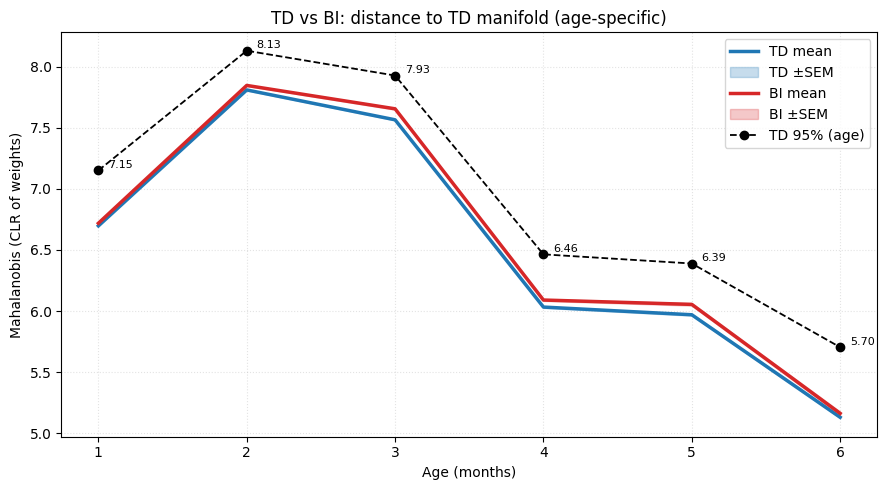

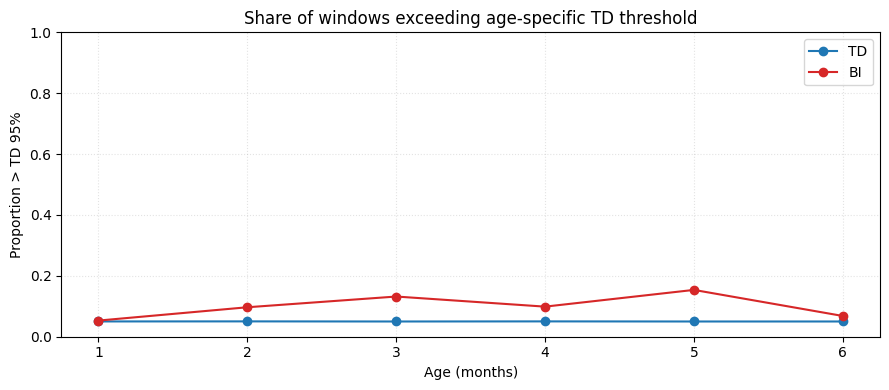

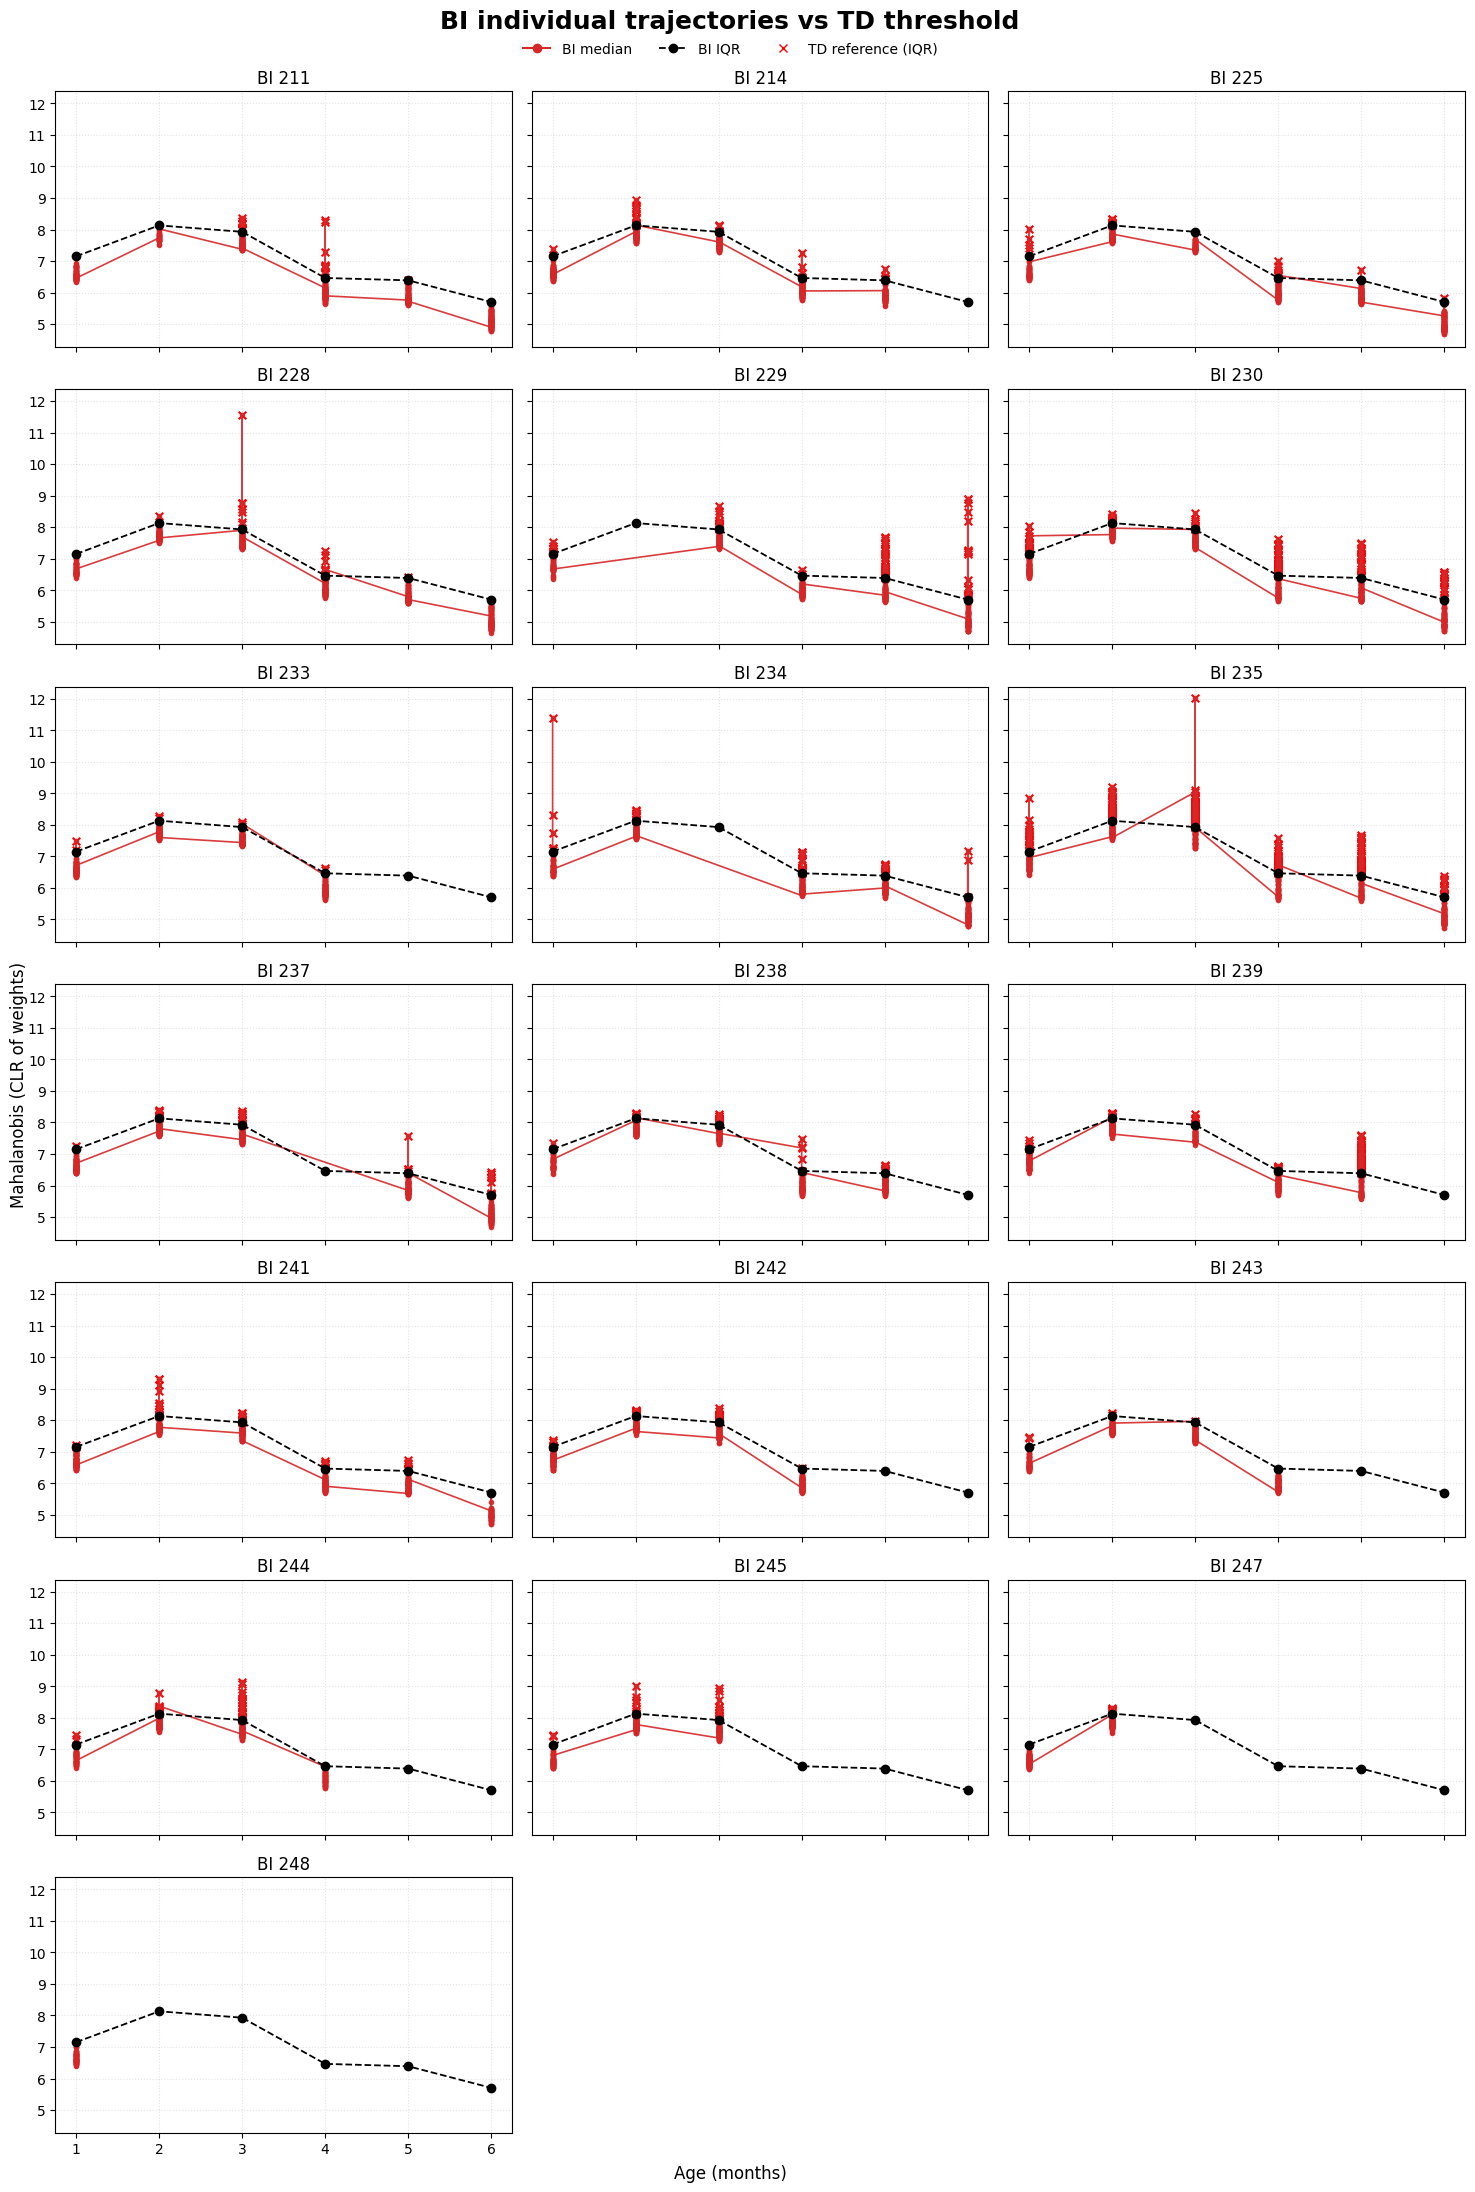

In [76]:
md_df, per_age_thr = compare_bi_to_td(merged, td_ref, space="weights_clr",
                                      save_csv="merged_with_md_weightsclr.csv")

Saved TD reference model:
  LOESS means → td_reference_features_means_features.csv
  Covariances → td_reference_features_cov_features.npz
  TD residuals → td_reference_features_residuals_features.csv
TD samples per age_bin: {1: 1893, 2: 2004, 3: 1799, 4: 1310, 5: 1979, 6: 1878}


C:\Users\ioana\AppData\Local\Temp\ipykernel_10428\3975693898.py:95: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  thr_s = thr_s.fillna(method="ffill").fillna(method="bfill").fillna(global_thr)


Saved: merged_with_md_features.csv
Non-NaN distances: 20744


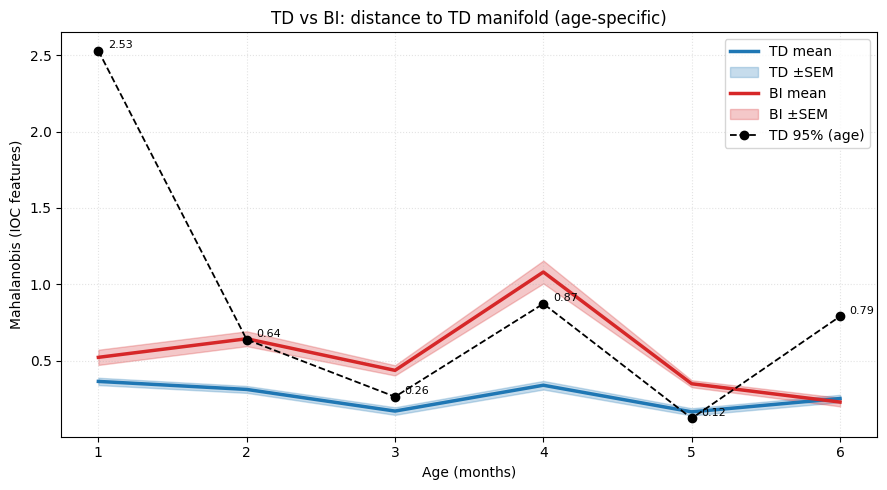

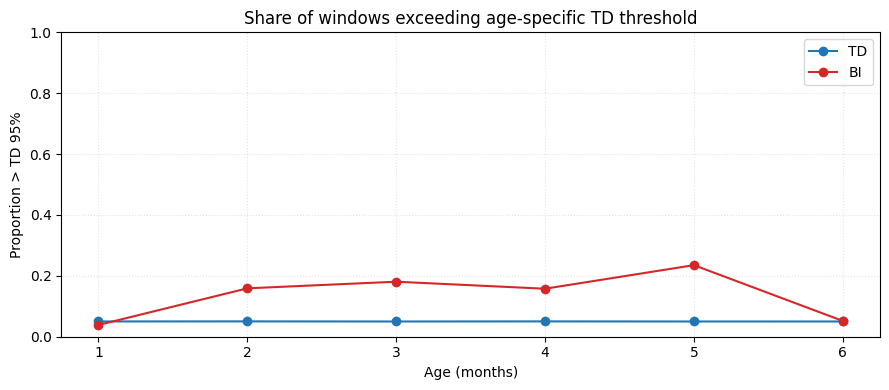

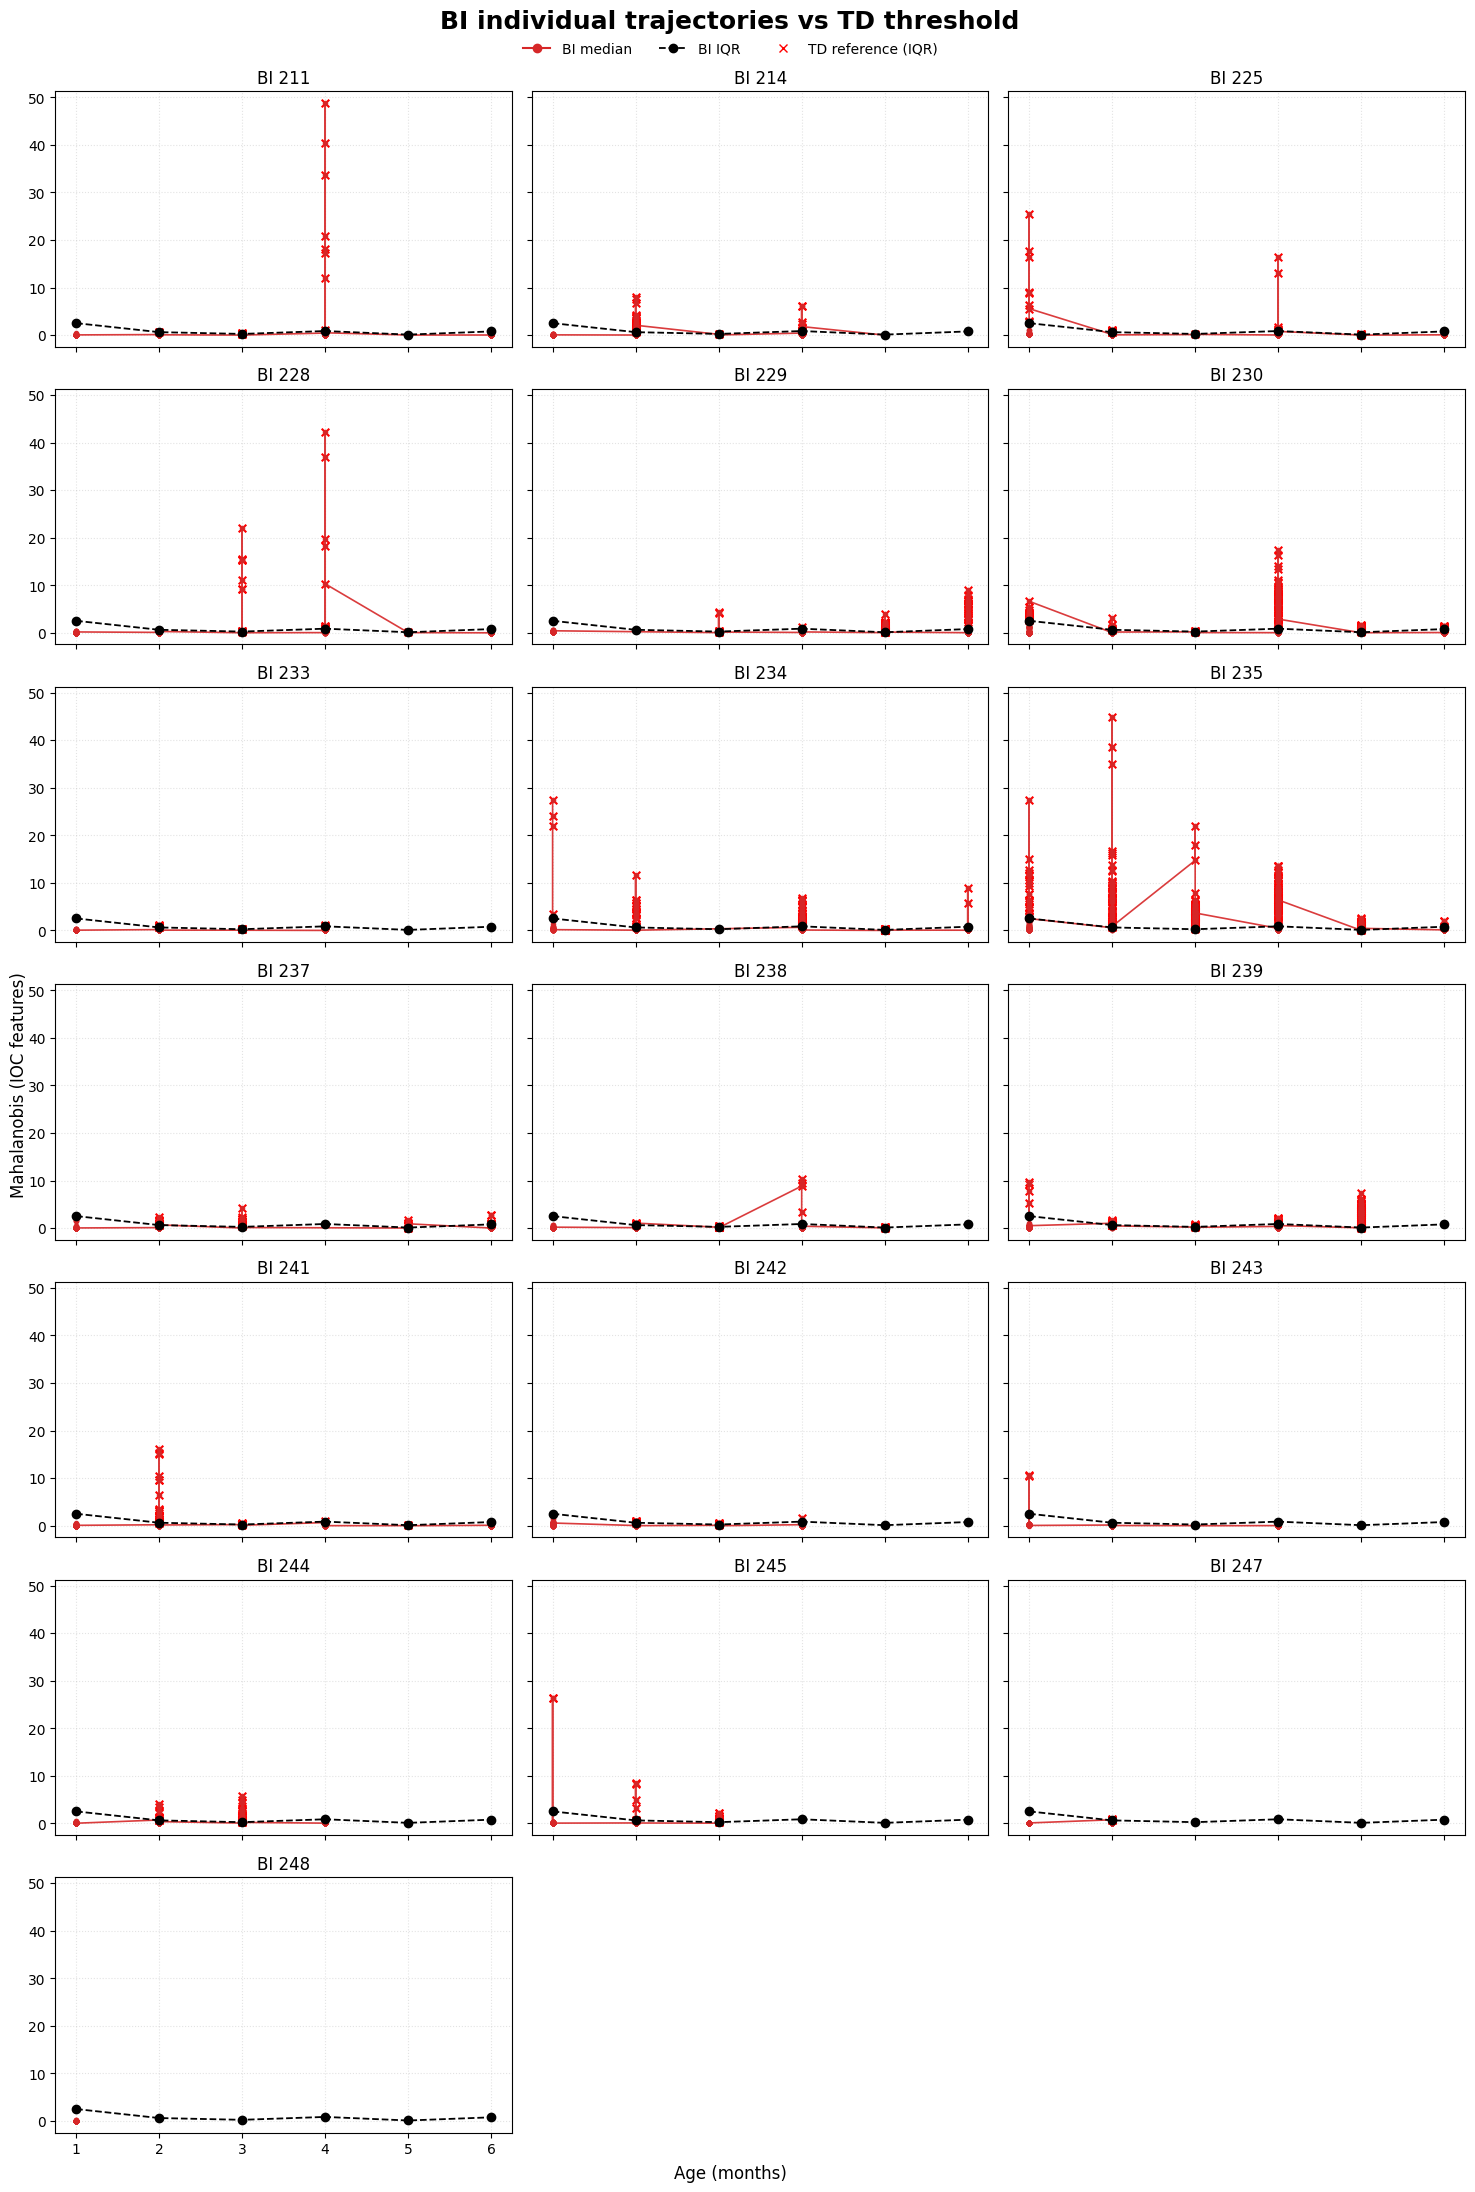

In [77]:
td_ref_feat = build_td_reference_model(
    merged,
    space="features",        
    loess_frac=0.30,
    save_prefix="td_reference_features"
)

# Now compare BI to TD in the same space
md_df, per_age_thr = compare_bi_to_td(
    merged,
    td_ref_feat,
    space="features",        # <-- must match the builder
    save_csv="merged_with_md_features.csv"
)

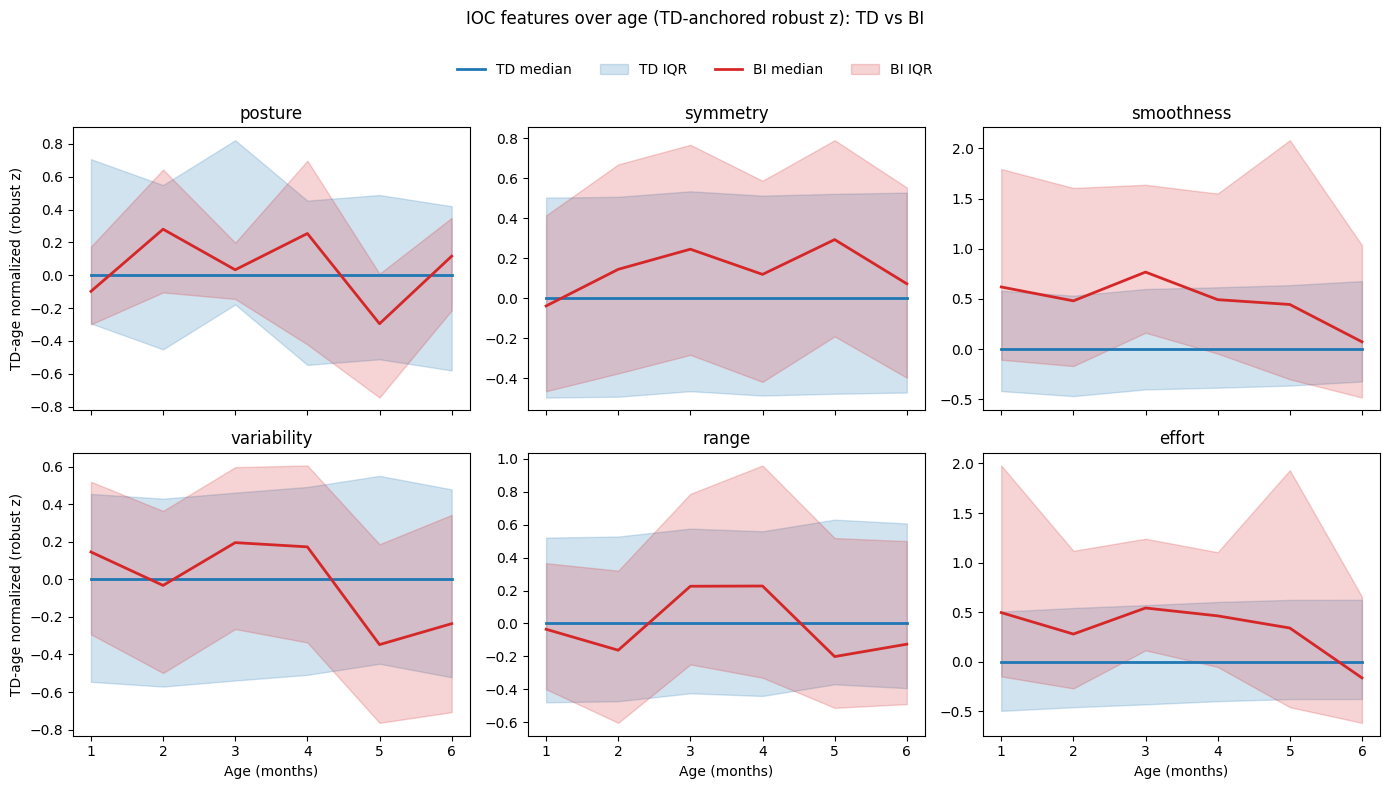

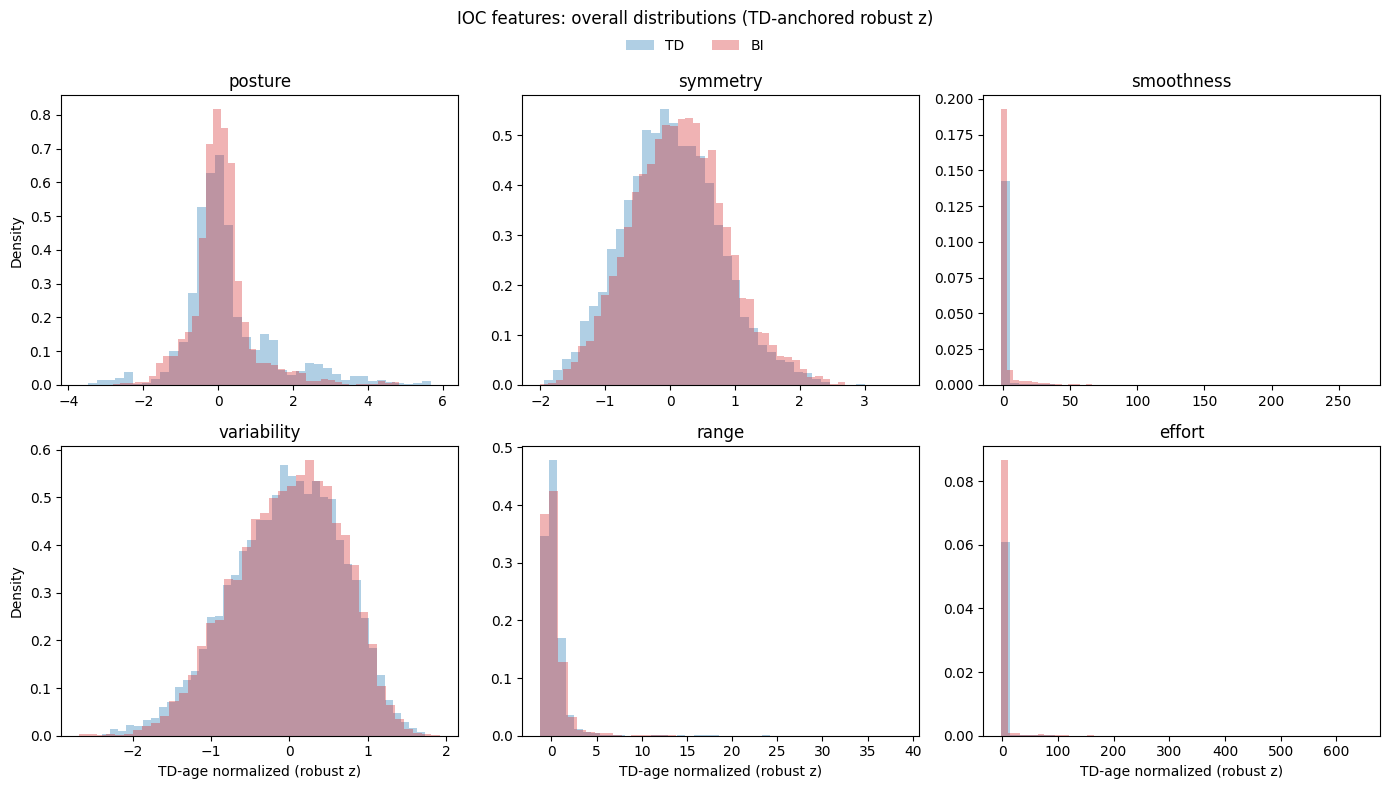

In [ ]:
terms = ["posture","symmetry","smoothness","variability","range","effort"]

df = merged.copy()  # or md_df.copy()
need = set(["label","age_months"]) | set(terms)
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in df: {missing}")

df["label"] = df["label"].astype(str).str.upper().str.strip()
df = df[df["label"].isin(["TD","BI"])].copy()
df["age_bin"] = np.floor(pd.to_numeric(df["age_months"], errors="coerce")).astype("Int64")
df = df.dropna(subset=["age_bin"]).copy()
df["age_bin"] = df["age_bin"].astype(int)

# --------------------------
# 1) Build TD per-age stats (median/IQR/mean/std), with robust filling
# --------------------------
def q25(s): return s.quantile(0.25)
def q75(s): return s.quantile(0.75)

td = df[df["label"]=="TD"].copy()
td_stats = td.groupby("age_bin")[terms].agg(["median", q25, q75, "mean", "std"])

# flatten columns: e.g., ('smoothness','median') -> 'smoothness_median'
td_stats.columns = [f"{feat}_{stat if isinstance(stat,str) else stat.__name__}"
                    for feat, stat in td_stats.columns]

# add IQR columns
for t in terms:
    td_stats[f"{t}_iqr"] = td_stats[f"{t}_q75"] - td_stats[f"{t}_q25"]

# ensure every age in data has TD stats via forward/back fill across the full age range
full_ages = range(int(df["age_bin"].min()), int(df["age_bin"].max())+1)
td_stats = td_stats.reindex(full_ages).ffill().bfill()

# --------------------------
# 2) Create age-specific robust z-scores relative to TD
#    ztd_feature = (x - TD_median(age)) / IQR_TD(age)
#    fallback to std if IQR==0; fallback to 1 if both 0
# --------------------------
eps = 1e-12
for t in terms:
    med = df["age_bin"].map(td_stats[f"{t}_median"])
    iqrv = df["age_bin"].map(td_stats[f"{t}_iqr"])
    stdv = df["age_bin"].map(td_stats[f"{t}_std"])

    denom = iqrv.copy()
    # fallback to std if iqr=0 or NaN
    denom = denom.where(denom > eps, other=stdv)
    # final fallback to 1.0 to avoid division by zero
    denom = denom.fillna(1.0).replace(0, 1.0)

    df[f"ztd_{t}"] = (df[t] - med) / denom

# --------------------------
# 3) Plot with normalized features (reuses plotting style)
# --------------------------
def agg_by_age_label(df_in, col, qlo=0.25, qhi=0.75):
    g = (
        df_in.groupby(["label","age_bin"], observed=True)[col]
             .agg(median="median",
                  q25=lambda s: s.quantile(qlo),
                  q75=lambda s: s.quantile(qhi),
                  n="size")
             .reset_index()
             .sort_values(["label","age_bin"])
    )
    return g

# Faceted age ribbons with normalized features
ncols, nrows = 3, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 8), sharex=True)
axes = axes.ravel()

for i, t in enumerate(terms):
    ax = axes[i]
    col = f"ztd_{t}"
    g = agg_by_age_label(df, col)
    for lbl, color in [("TD","tab:blue"), ("BI","tab:red")]:
        d = g[g["label"]==lbl]
        if d.empty: 
            continue
        x = d["age_bin"].to_numpy()
        m = d["median"].to_numpy()
        lo = d["q25"].to_numpy()
        hi = d["q75"].to_numpy()
        ax.plot(x, m, lw=2, color=color, label=f"{lbl} median")
        ax.fill_between(x, lo, hi, color=color, alpha=0.2, label=f"{lbl} IQR")
    ax.set_title(t)
    if i % ncols == 0: ax.set_ylabel("TD-age normalized (robust z)")
    if i // ncols == nrows-1: ax.set_xlabel("Age (months)")

handles, labels = axes[0].get_legend_handles_labels()
fig.tight_layout(rect=[0, 0, 1, 0.88])  # reserve top space
fig.suptitle("IOC features over age (TD-anchored robust z): TD vs BI", y=0.98)
fig.legend(handles, labels, loc="upper center", ncol=4, bbox_to_anchor=(0.5, 0.93), frameon=False)
plt.show()

# Overall distributions of normalized features
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 8), sharex=False)
axes = axes.ravel()
for i, t in enumerate(terms):
    ax = axes[i]
    col = f"ztd_{t}"
    td_vals = df.loc[df["label"]=="TD", col].to_numpy()
    bi_vals = df.loc[df["label"]=="BI", col].to_numpy()
    td_vals = td_vals[np.isfinite(td_vals)]
    bi_vals = bi_vals[np.isfinite(bi_vals)]
    if len(td_vals):
        ax.hist(td_vals, bins=40, density=True, alpha=0.35, color="tab:blue", label="TD")
    if len(bi_vals):
        ax.hist(bi_vals, bins=40, density=True, alpha=0.35, color="tab:red", label="BI")
    ax.set_title(t)
    if i % ncols == 0: ax.set_ylabel("Density")
    if i // ncols == nrows-1: ax.set_xlabel("TD-age normalized (robust z)")

handles, labels = axes[0].get_legend_handles_labels()
fig.tight_layout(rect=[0, 0, 1, 0.92])
fig.suptitle("IOC features: overall distributions (TD-anchored robust z)", y=0.98)
fig.legend(handles, labels, loc="upper center", ncol=4, bbox_to_anchor=(0.5, 0.96), frameon=False)
plt.show()

# Visualizations and Reporting

- Plot trajectories of cost weights over age for TD and BI groups.
- Plot Mahalanobis distance over age to show divergence points.
- Include individual-level plots for qualitative inspection.